In [ ]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Intro to Optimizers

In a previous module in this course, we began by writing gradient descent from scratch. Soon after, we replaced this code with an optimizer. In this module, we'll learn about optimizers by writing a few of our own. We'll also observe how adjusting different parameters for those optimizers can adjust how a simple model is trained.

As we saw in the first lesson, optimizers use the gradient of the parameters with respect to the loss to update weights. Over model training, the optimizer helps find parameters that minimize the loss function.

There are many optimizers, but most of them are different "flavors" of stochastic gradient descent (SGD). (What deep learning libraries call SGD is actually minibatch gradient descent, but we won't hold that against them.) There are a number of methods that help optimizers reach minima in the loss landscape more quickly. In this module, we'll go over some of those methods.

Keep in mind that loss landscapes are more convex with simple linear models like we're using now. As our models become more complex, the loss landscape becomes non-convex, meaning that there may be multiple minima in the loss function. This also means we may not be able to observe large differences between optimizers, while in practice these differences may represent significint savings in training time or model performance.

Let's Make a Dataset

In this module, we want to understand what these optimizers are doing visually. To easily visualize what these optimizers are doing, we'll make a really simple 2-variable dataset. This way, we can visualize in just 2 dimensions what happens to the loss function as we change our parameters. The next section of code makes a really simple dataset.

In [ ]:
N_SAMPLES = 1000
noise = torch.randn(N_SAMPLES) * 3    #Multiplica por 3 los numeros, no anade tres veces mas de numeros
# Pick the values of the parameters we want to learn
param_1_actual = 8.765
param_2_actual = -4.321

def f(xs, param1=param_1_actual, param2=param_2_actual, add_noise=True):
    """
    This function generates Ys from xs. xs should be a torch.tensor with two columns.
    The default for param1 and param2 are given, but we may want to change them later.
    By default, we'll add noise but we'll see some other visualizations are
    cleaner when we remove it.
    """
    params = torch.tensor([param1, param2]).float()
    out = xs@params
    if add_noise:
        out.add_(torch.randn(xs.shape[0]) * 3)    #add of torch, genera numeros aleatorios=numero de filas para simular ruido y lo anade
    return out

NameError: ignored

In [ ]:
# Create the xs
xs = torch.randn(N_SAMPLES, 2)

In [ ]:
xs.shape

torch.Size([1000, 2])

In [ ]:
# Create the ys
ys = f(xs)

In [ ]:
ys.shape

torch.Size([1000])

In [ ]:
vec1=torch.tensor([1,1]).float()    #Comprobacion de la funcion
vect2=torch.tensor([2,2]).float()

In [ ]:
vec1@vect2

tensor(4.)

# Exercise 6.1: Make a dataset

Use what you know from previous lessions to complete the class `MyDataset`.
Then, use the `xs` and `ys` we created to instantiate your dataset and a `DataLoader` with `batch_size=32` and `shuffle=True`.
<!-- startquestion -->

In [ ]:
class MyDataset(Dataset):
    def __init__(self,X,y):
      super().__init__()
      self.X=X
      self.y=y

    def __len__(self):
      return len(self.y)

    def __getitem__(self,idx):
      return self.X[idx], self.y[idx]


# Create the dataset
ds = MyDataset(xs,ys)
# Create the dataloader
dl = DataLoader(
    ds,
    batch_size=64,
    shuffle=True, # we generally want to shuffle the train dataloader
    num_workers=2
)

In [ ]:
assert isinstance(ds, Dataset)
assert isinstance(dl, DataLoader)

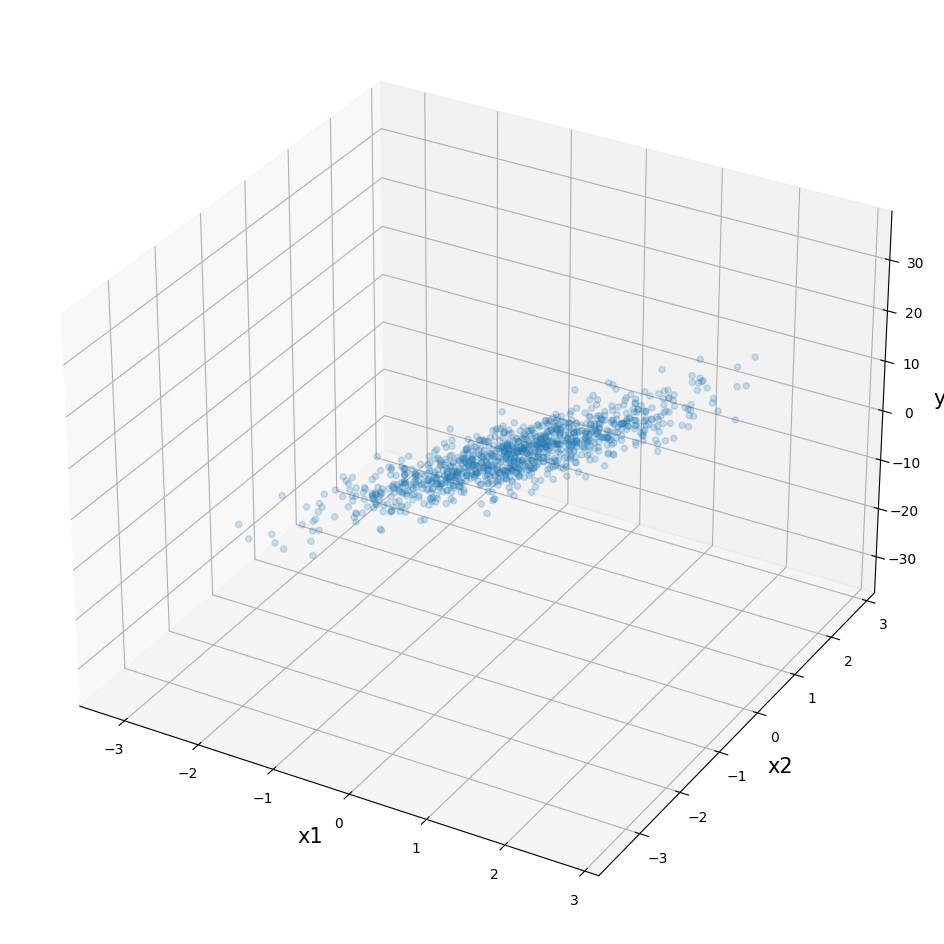

In [ ]:
# Visualize a sample of our data
_df = pd.DataFrame(xs.numpy(), columns=['x1', 'x2'])
_df['y'] = ys.numpy()
data_fig = plt.figure(figsize=(12,12))
ax = data_fig.add_subplot(projection='3d')
ax.scatter(_df.x1, _df.x2, _df.y, alpha=0.2)
ax.set_xlabel('x1', fontsize=15)
ax.set_ylabel('x2', fontsize=15)
ax.set_zlabel('y', fontsize=15)
plt.close()
data_fig

# Exercise 6.2: Create a small neural network

Please complete the class `Net` by completing the `__init__` and `forward` methods.
Your parameters should contain a float tensor with two elements, one for $x_1$ and one for $x_2$.
Please initialize each of those parameters to the value 3.0.
The `forward` method should multiply your inputs by these parameters.
In this case, let's ignore the bias parameter, since we didn't use it in creating our dataset.

<!-- startquestion -->

In [ ]:
from torch import nn

In [ ]:
import torch

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(torch.tensor([3.,3.]).float())

    def forward(self, x):
        return x@self.params

In [ ]:
assert Net()(torch.tensor([[1., 1.]])) == 6 # Check the outputs against a known input
assert (next(Net().parameters()).data == torch.tensor([3., 3.])).all() # Check that the parameters are all 3

In [ ]:
def get_parameters_over_training(optimizer, opt_kwargs={'lr':1e-3}):
    """
    This function is used to learn about different optimizers.
    The optimizer argument is a class from torch.optim,
    and the opt_kwargs is a dictionary of keyword arguments to pass
    to the optimizer as it's instantiated.

    This function returns a tuple of (params_history, losses)
    where params_history is a numpy array where each column represents
    the history of a parameter as the model's trained.
    The losses are just the loss at every step.
    """
    # Instantiate our network
    model = Net()
    # Instantiate the optimizer
    opt = optimizer(model.parameters(), **opt_kwargs)   #This is how it links the Net to optimizer
    # Create placeholders for the params history and losses
    params_history = []
    losses = []
    # Instantiate the loss
    loss = nn.MSELoss()
    # Train the model for 50 epochs
    for epoch in range(50):
        for x_b, y_b in ds:
            # Make predictions
            preds = model(x_b)
            # Log the parameters
            c = model.params.clone().detach().numpy()     #Este es el encargado en registrar los parametros que van cambiando
            params_history.append(c)
            # Calculate and record the loss
            l = loss(preds, y_b)
            losses.append(l.clone().detach().numpy())
            # Calculate the gradients
            l.backward()
            # Apply the optimizer update and zero the gradients
            opt.step()    #Parece que el optimizador esta linkado a 'Net' mediante 'model.parameters'. El uno esta linkado al otro
            opt.zero_grad()   #El optimizador actualiza los pesos y los manda a 'Net' que al empezar el bucle tiene los parametros actualizados.
        if epoch % 10 == 0:
            print(l.detach().numpy(), c)
    return np.vstack(params_history), np.hstack(losses)

In [ ]:
def loss_fig(smooth=True):
    """
    Plots a contour map of the loss.
    If smooth = True, the landscape will look like nice circles.
    While this is a nicer visualization, the actual loss landscape
    is hinted at when smooth = False.

    Returns a pyplot.Figure
    """
    p1r = np.linspace(2, 10)
    p2r = np.linspace(4, -10)
    X, Y = np.meshgrid(p1r, p2r)
    Z = np.zeros_like(X)
    rows, cols = X.shape
    for i in range(rows):
        for j in range(cols):
            preds = f(xs, X[i,j], Y[i,j], add_noise=not smooth)
            Z[i,j] = float(nn.MSELoss()(preds, ys).numpy())
    fig, ax = plt.subplots(figsize=(12, 12))
    CS = ax.contour(X, Y, Z, levels=[.1, 1, 2, 4, 8, 16, 32, 64], colors='k')
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_xlabel('Param 1')
    ax.set_ylabel('Param 2')
    plt.close()
    return fig

def plot_losses(losses, n_steps=None):
    """
    Plots a list of losses, assuming it's MSE loss.
    Returns a plt.Figure.
    """
    if n_steps:
        ls = pd.Series(losses[n_steps])
    else:
        ls = pd.Series(losses)
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(ls, label='MSE')
    ax.plot(ls.rolling(100).mean(), label='MSE rolling mean')
    ax.set_xlabel('Step')
    ax.set_ylabel('Mean squared error')
    ax.legend()
    plt.close()
    return fig

In [ ]:
from torch import optim

Stochastic Gradient Descent

The most basic optimizer is stochastic gradient descent. During the training process, we use the model outputs and targets to calculate the loss, and loss.backward() performs backpropagation to calculate the gradients for the model parameters. Using these gradients, we want to take a step in the direction that the gradients say will decrease the loss. The step size is defined by the learning rate parameter. All we do is multiply the gradients by the learning rate, and sutract this value from our parameters.

Let's remind ourselves what vanilla sgd is doing in pseudocode:

for step in steps:

    update = learn rate * this step's gradients
    
    new params = current params - update

In [ ]:
# Write our own sgd optimizer
class SGD(optim.Optimizer):
    def __init__(self, params, lr):
        # Store the params and defaults in the Optimizer parent class
        super().__init__(params, defaults=dict(lr=lr))
        self.lr = lr

    def step(self):
        # For each param group
        for group in self.param_groups:       #esto va dentro del modulo optim.Optimizer
            # Fetch the parameters
            for p in group['params']:
                # Apply SGD update rule
                # Note: sub_ is an in-place subtraction
                p.data.sub_(p.grad * self.lr)             #Sub=sbstract

In [ ]:
sgd_params, sgd_losses = get_parameters_over_training(SGD)

19.202087 [ 7.760349  -3.4200842]
39.942932 [ 8.613067 -4.426094]
39.942932 [ 8.613067 -4.426094]
39.942932 [ 8.613067 -4.426094]
39.942932 [ 8.613067 -4.426094]


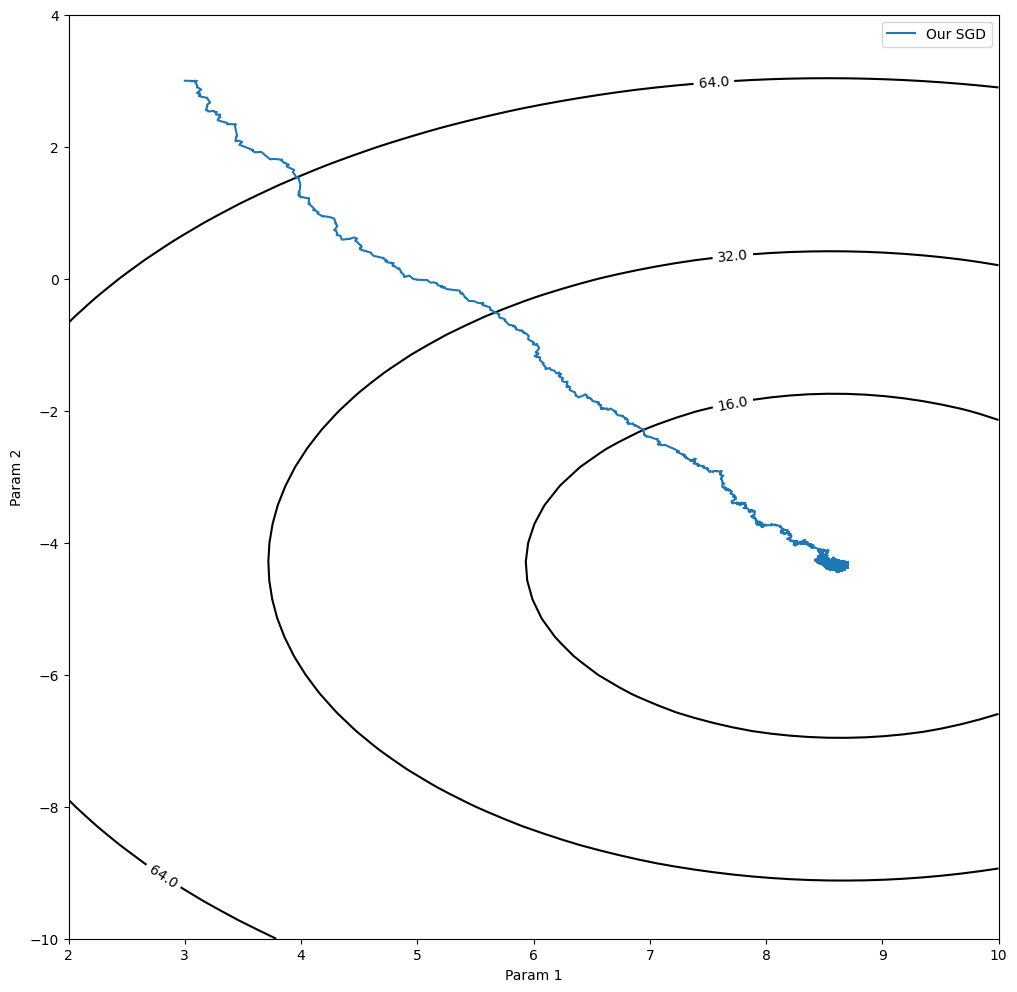

In [ ]:
fig = loss_fig(True) # Try this with smooth=False so we can see that the actual loss landscape is bumpy
ax = fig.gca()
ax.plot(sgd_params[:,0], sgd_params[:,1], label='Our SGD')
ax.legend()
fig

In [ ]:
sgd_params, sgd_losses = get_parameters_over_training(optim.SGD)

19.202095 [ 7.7603493 -3.420084 ]
39.942932 [ 8.613067 -4.426094]
39.942932 [ 8.613067 -4.426094]
39.942932 [ 8.613067 -4.426094]
39.942932 [ 8.613067 -4.426094]


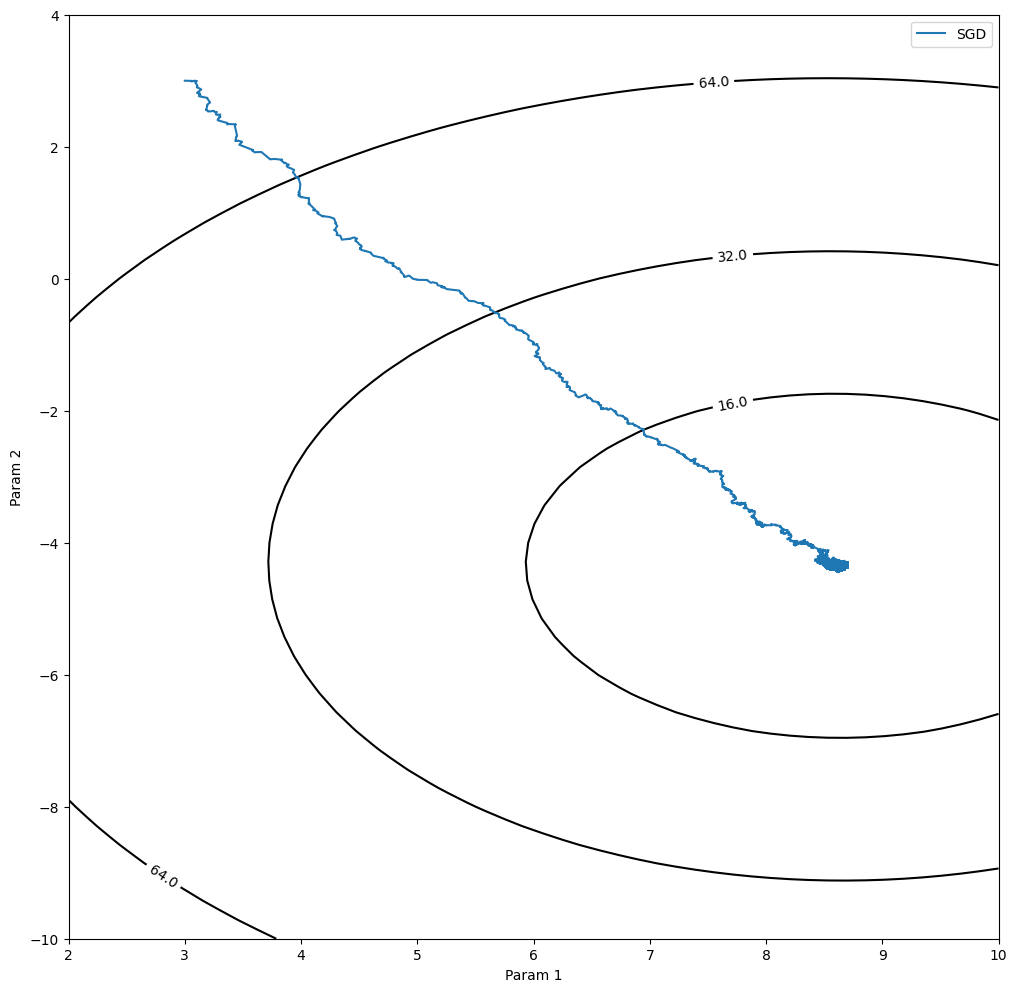

In [ ]:
fig = loss_fig(True) # Try this with smooth=False so we can see that the actual loss landscape is bumpy
ax = fig.gca()
ax.plot(sgd_params[:,0], sgd_params[:,1], label='SGD')
ax.legend()
fig

In this lesson, we implemented our own stochastic gradient descent optimizer and saw how it helped improve our parameters to minimize our loss function.

With a few tricks, we can find the minimum of a loss function with fewer steps. In the rest of this module, we'll go through a few of the different methods optimizers use to help networks converge on a minimum faster, and try to provide some intuition on how they work.

for step in steps:

    avg = beta * last avg - learn rate *  this step's gradients
    
    new params = current params - avg

In [ ]:
class SGDWithMomentum(optim.Optimizer):
    def __init__(self, params, lr, momentum=0.9):
        defaults=dict(
            lr=lr,
            momentum=momentum
        )
        super().__init__(params, defaults=defaults)
        self.lr = lr
        self.momentum = momentum


    def step(self):
        # Iterate through all the parameters in the model
        for group in self.param_groups:
            for p in group['params']:
                # if the parameter doesn't ahve an "avg" attribute,
                # let's create one as a tensor of zeros.
                if not hasattr(p, 'avg'):
                    p.avg = torch.zeros_like(p.grad.data)
                # Let's update the moving average with the new update
                p.avg = self.momentum * p.avg - self.lr * p.grad
                # Finally, let's perform the parameter update step.
                p.data.add_(p.avg)

SGD With Momentum

With vanilla SGD, we look at the current gradient of a batch each time we make a parameter update. To change that, we can use a moving average of the gradient instead of only the current gradient.

What if the optimizer had some "memory" of the direction it was headed before the current batch? This is what momentum does. In a bumpy loss landscape, momentum helps the optimizer skip over local minima to reach more of a global minimum. There is only one parameter we care about here, called beta \(\beta\). If \(\beta\) is small, we're much closer to vanilla SGD, where we use the gradients from the current batch. If \(\beta\) is large, we rely on a moving average of gradients from the past. Let's see this in pseudocode:

https://optimization.cbe.cornell.edu/index.php?title=Momentum

In [ ]:
sgd_mom_params, sgd_mom_losses = get_parameters_over_training(SGDWithMomentum, opt_kwargs={'lr':1e-3, 'momentum':0.9})

44.624527 [ 8.42727   -4.8499675]
44.624527 [ 8.42727   -4.8499675]
44.624527 [ 8.42727   -4.8499675]
44.624527 [ 8.42727   -4.8499675]
44.624527 [ 8.42727   -4.8499675]


In this case, we approach the minimum of our loss function in fewer steps. However, wince we have so much momentum, we overshoot the minimum.

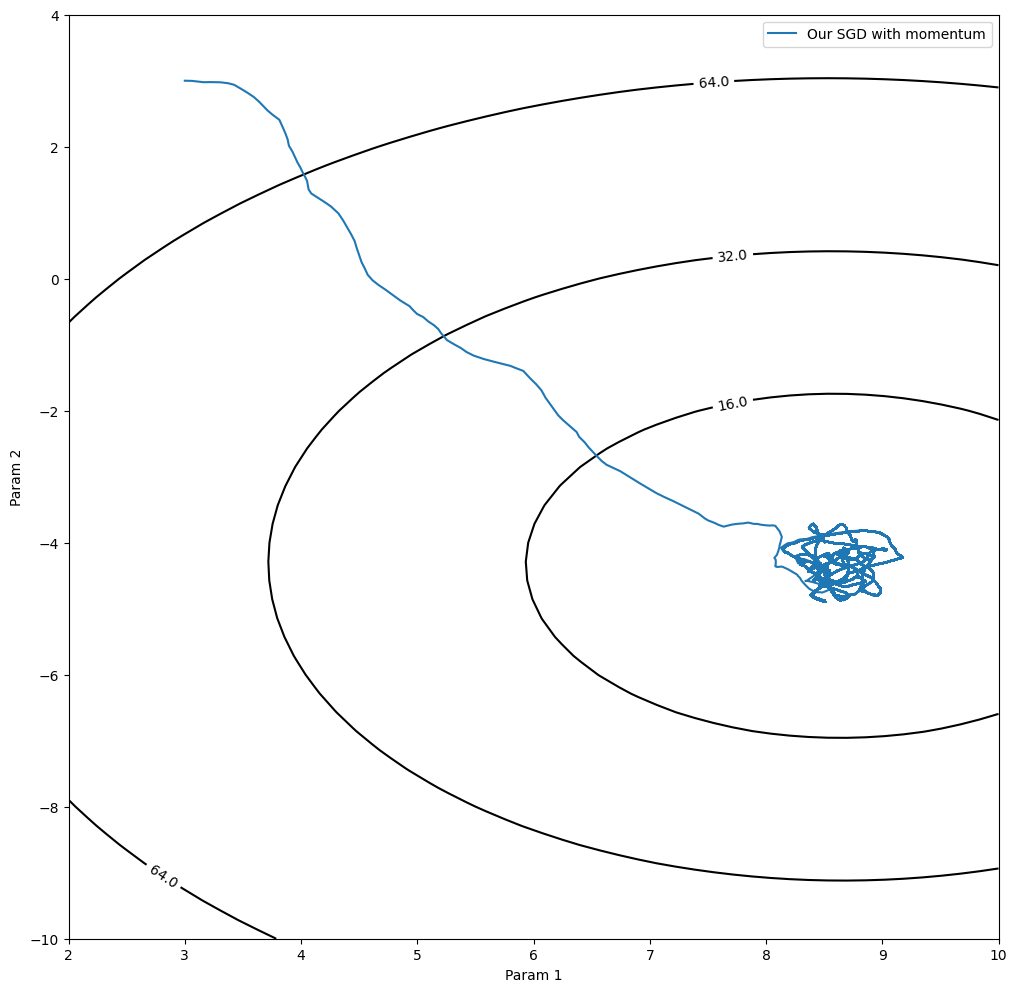

In [ ]:
fig = loss_fig(True) # Try this with smooth=False so we can see that the actual loss landscape is bumpy
ax = fig.gca()
ax.plot(sgd_mom_params[:,0], sgd_mom_params[:,1], label='Our SGD with momentum')
ax.legend()
fig

Now, let's use torch.optim.SGD with momentum to evaluate different \(\beta\)s (momentums). Remember, a high momentum favors past updates, and a low momentum favors more recent updates.

In [ ]:
sgd_small_mom_params, sgd_small_mom_losses = get_parameters_over_training(optim.SGD, opt_kwargs={'lr':1e-3, 'momentum':0.1})
sgd_med_mom_params, sgd_med_mom_losses = get_parameters_over_training(optim.SGD, opt_kwargs={'lr':1e-3, 'momentum':0.5})
sgd_large_mom_params, sgd_large_mom_losses = get_parameters_over_training(optim.SGD, opt_kwargs={'lr':1e-3, 'momentum':0.9})

22.742867 [ 7.9199395 -3.6282697]
40.034866 [ 8.610828 -4.433609]
40.034866 [ 8.610828 -4.433609]
40.034866 [ 8.610828 -4.433609]
40.034866 [ 8.610828 -4.433609]
37.316475 [ 8.4583435 -4.3588963]
40.657085 [ 8.584604  -4.4919167]
40.657085 [ 8.584604  -4.4919167]
40.657085 [ 8.584604  -4.4919167]
40.657085 [ 8.584604  -4.4919167]
44.624527 [ 8.42727  -4.849967]
44.624527 [ 8.42727  -4.849967]
44.624527 [ 8.42727  -4.849967]
44.624527 [ 8.42727  -4.849967]
44.624527 [ 8.42727  -4.849967]


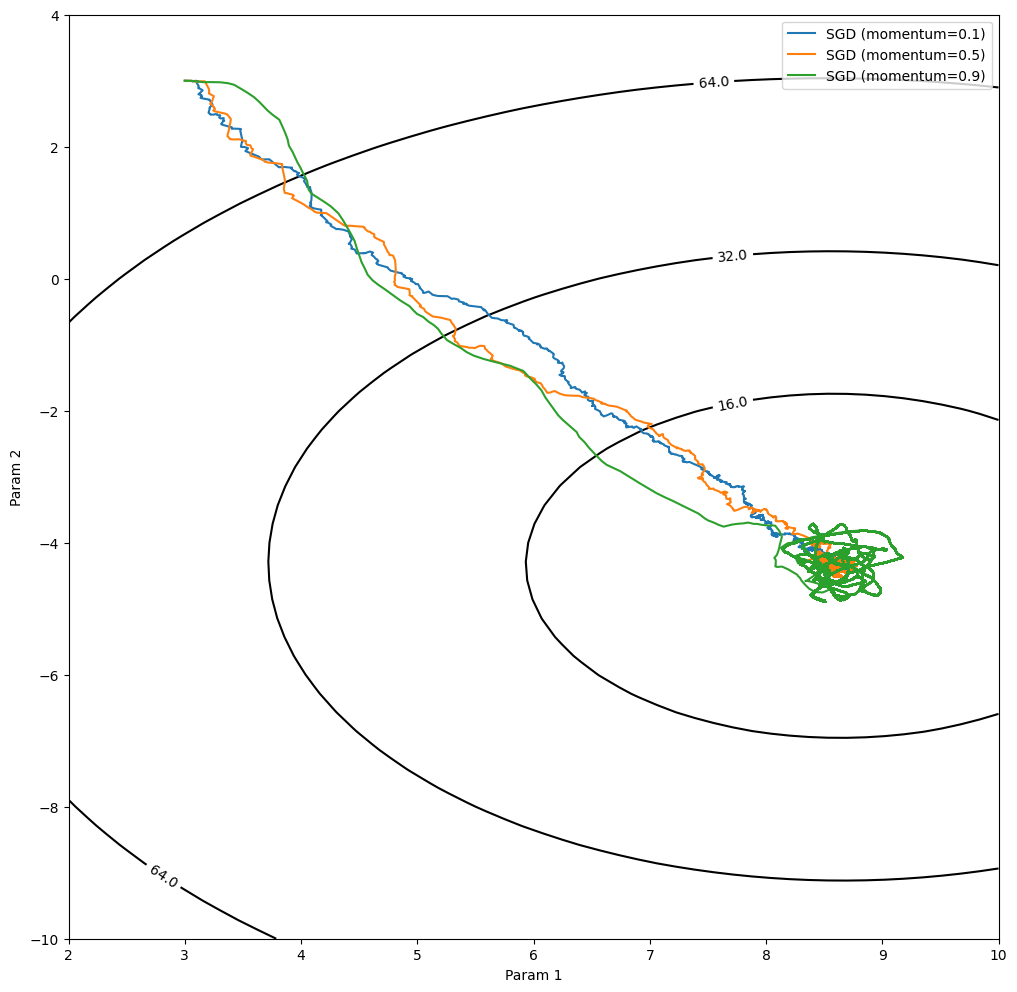

In [ ]:
fig = loss_fig(True) # Try this with smooth=False so we can see that the actual loss landscape is bumpy
ax = fig.gca()
ax.plot(sgd_small_mom_params[:,0], sgd_small_mom_params[:,1], label='SGD (momentum=0.1)')
ax.plot(sgd_med_mom_params[:,0], sgd_med_mom_params[:,1], label='SGD (momentum=0.5)')
ax.plot(sgd_large_mom_params[:,0], sgd_large_mom_params[:,1], label='SGD (momentum=0.9)')
ax.legend()
fig

We can see that momentum can really smooth out our path to the mimimum. However, from looking at the logs above, we aren't able to achieve the same loss that we did with lower or no momentum.

We can see that as we increase the momentum, our path towards the minimum is not as sensitive to the gradients at each step (less squiggly). One issue though is that with a high momentum, we may overshoot our minimum.

RMSProp

RMSProp considers that different parameters might benefit from different learning rates. If certain parameters haven't received large updates in a while, we can If a parameter's gradient's updates (or their histories) are small, that means that the slope of the loss with respect to that parameter is relatively small. Thus, we can give parameters with small gradients larger updates. Instead of just updating using the gradients, we scale them by the moving average of the squared gradients. Let's take a look at the pseudocode for this:

for step in steps:
    new squared average gradients = alpha * last squared average gradients + (1 - alpha) * (this step's gradients)**2
    update = learn rate * this step's gradients / sqrt(new squared average gradients + epsilon)
    new params = current params - update

We scale the gradients by a moving average of the square of the gradients, stored in new squared average. The main hyperparameter for this trick is alpha (\(\alpha\)), which weights the moving average of the squared gradients. In this case, epsilon is a really small number, usually 1e-8 that's added for numerical stability. That is, we don't want the denominator to get too small and lead to large updates.


for step in steps:
    new squared average gradients = alpha * last squared average gradients + (1 - alpha) * (this step's gradients)**2

    update = learn rate * this step's gradients / sqrt(new squared average gradients + epsilon)
    
    new params = current params - update

In [ ]:
class RMSProp(optim.Optimizer):
    def __init__(self, params, lr, alpha=0.9, eps=1e-8):
        defaults=dict(
            lr=lr,
            alpha=alpha
        )
        super().__init__(params, defaults=defaults)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps


    def step(self):
        # Iterate through the parameters
        for group in self.param_groups:
            for p in group['params']:
                # If the parameter doesn't have a squared gradient attribute,
                # let's add one
                if not hasattr(p, 'sq_grad'):
                    p.sq_grad = torch.zeros_like(p.grad.data)
                # Update the squared gradient attribute
                p.sq_grad = self.alpha * p.sq_grad + (1 - self.alpha) * p.grad.data**2
                # Using the squared gradient attribute, calculate the update
                update = p.grad * self.lr / p.sq_grad.add(self.eps).sqrt()
                # Apply the update to the parameters
                p.data.sub_(update)

In [ ]:
rms_params, rms_losses = get_parameters_over_training(RMSProp)

41.17047 [3.422926 2.470114]
7.008012 [ 7.1998243 -2.3800354]
35.098503 [ 8.486864 -4.187765]
38.14716 [ 8.581575 -4.329654]
38.34129 [ 8.5873995 -4.3385468]


We can see that this is an improvement over SGD, even with momentum. We take a relatively straight path from our the starting point of our parameters to the minimum of our loss function.

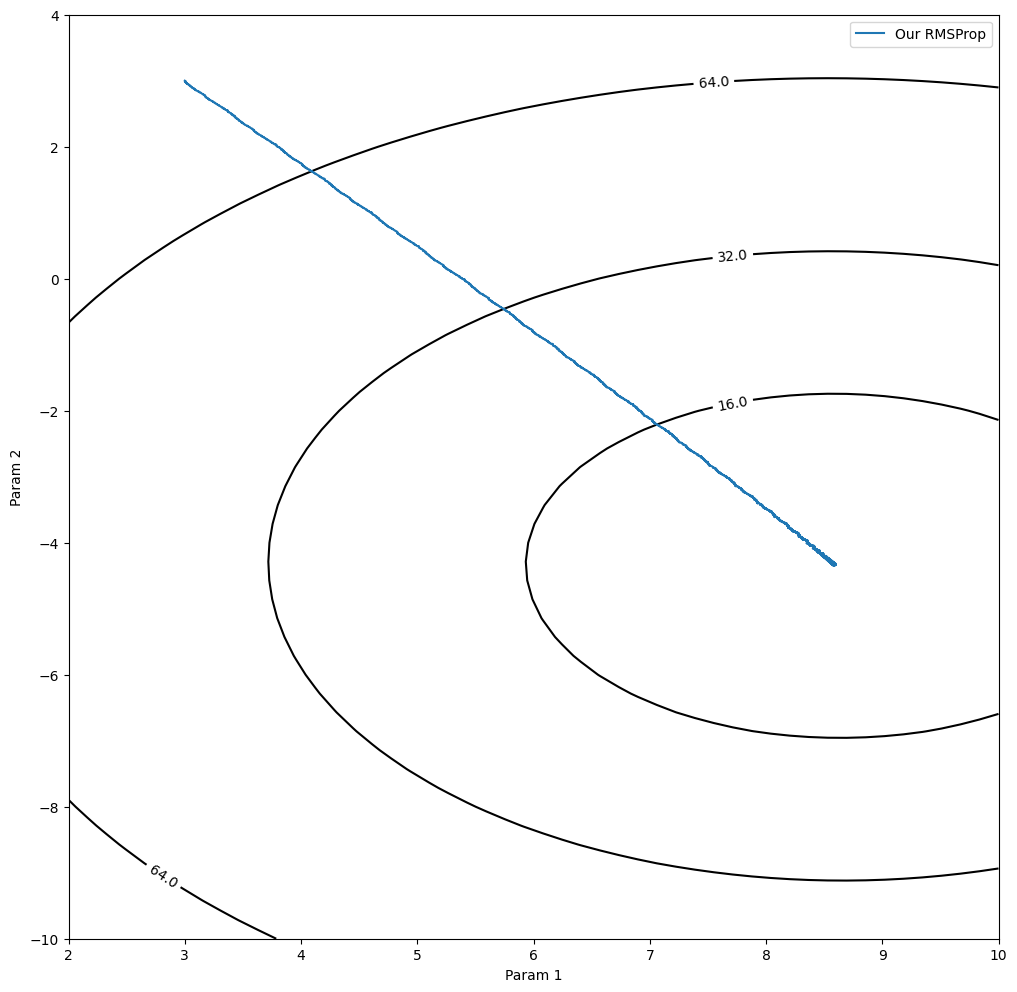

In [ ]:
fig = loss_fig(True) # Try this with smooth=False so we can see that the actual loss landscape is bumpy
ax = fig.gca()
ax.plot(rms_params[:,0], rms_params[:,1], label='Our RMSProp')
ax.legend()
fig

Let's see if we can replicate the same results with torch.optim.RMSProp. While we dont' see exactly the same thing, we generally observe that the training paths are similar. There may be some optimizations in torch's implementation that we haven't considered.

In [ ]:
rms_params, rms_losses = get_parameters_over_training(optim.RMSprop, opt_kwargs={'lr':1e-3})

39.41084 [3.4704049 2.3888597]
7.8784976 [ 7.3100905 -2.4353216]
36.430668 [ 8.530709 -4.249137]
38.700928 [ 8.604287 -4.350737]
38.800022 [ 8.607914  -4.3547826]


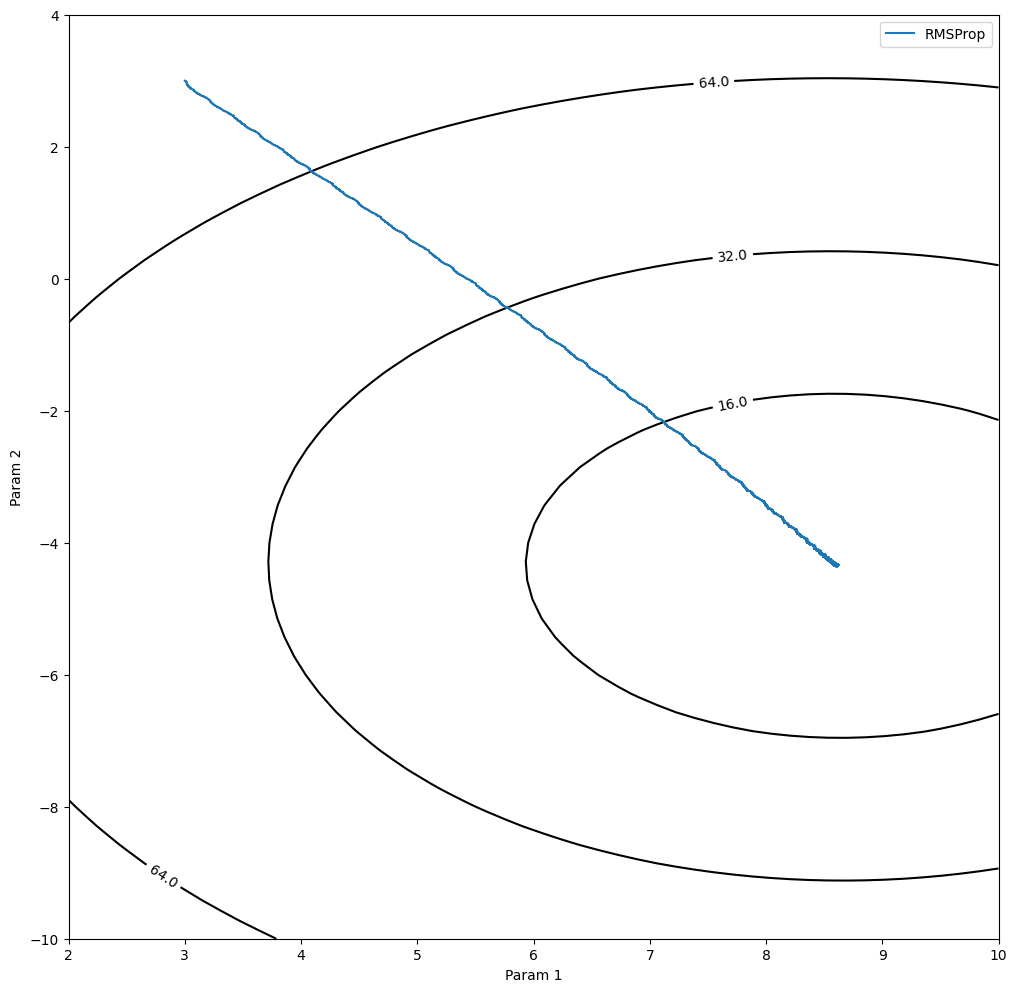

In [ ]:
fig = loss_fig(True) # Try this with smooth=False so we can see that the actual loss landscape is bumpy
ax = fig.gca()
# ax.plot(sgd_params[:,0], sgd_params[:,1], label='SGD')
ax.plot(rms_params[:,0], rms_params[:,1], label='RMSProp')
ax.legend()
fig

In this lesson, we learned about RMSProp, which has a different approach to momentum. Instead of using a momentum term with the gradients themselves, it keeps a exponentially weighted moving average of the squares of the gradients, which are used to scale the updates.

Adam

If you don't know what optimizer to use, Adam is usually a good one. Adam stands for adaptive moment estimation, and combines the ideas of momentum and RMSProp. It keeps track of exponentially decaying average of the past squared gradients like RMSProp, and also keeps track of an exponentially decaying average of past gradients like momentum. Many higher-level libraries use this one by default. Let's see the pseudocode:

for step in steps:
    # Momentum
    average gradients = beta * moving average of gradients + (1 - beta) * this step's gradients
    unbiased average gradients = average gradients / (1 - (beta**(setp number+1)))
    # RMSProp
    new squared average = alpha * last squared average + (1 - alpha) * (this step's gradients)**2
    # Update
    update = learn rate * unbiased average gradients / sqrt(new squared average + epsilon)
    new params = current params - update

In [ ]:
class Adam(optim.Optimizer):
    def __init__(self, params, lr, grad_mom=0.9, rms_mom=0.99, eps=1e-8):
        defaults=dict(
            lr=lr,
            grad_mom=grad_mom,
            rms_mom=rms_mom,
            eps=eps
        )
        super().__init__(params, defaults=defaults)
        self.lr = lr
        self.grad_mom = grad_mom
        self.rms_mom = rms_mom
        self.eps = eps
        self.step_no = 0

    def step(self):
        # Iterate through the parameters
        for group in self.param_groups:
            for p in group['params']:
                # If the parameters dont' have records of the average or squared
                # average, let's add them
                if not hasattr(p, 'avg'):
                    p.avg = torch.zeros_like(p.grad.data)
                    p.sq_avg = torch.zeros_like(p.grad.data)
                # First, let's calculate the moving average update
                p.avg = self.grad_mom * p.avg + (1 - self.grad_mom) * p.grad.data
                ma_update = p.avg / (1 - self.grad_mom**self.step_no)

                # Next, let's calculate the RMS update
                p.sq_avg = self.rms_mom * p.sq_avg + (1 - self.rms_mom) * p.grad.data**2
                rms_update = p.sq_avg / (1 - self.rms_mom**self.step_no)

                # Finally, we'll combine the grad and sq grad updates
                # into the final update, then apply the update to our params.
                update = self.lr * p.avg / p.sq_avg.add(self.eps).sqrt()
                p.data.sub_(update)
                self.step_no += 1

In [ ]:
adam_params, adam_losses = get_parameters_over_training(Adam)

40.01654 [3.4604244 2.4214904]
7.709531 [ 7.2992396 -2.417917 ]
36.40026 [ 8.528242 -4.248764]
38.691006 [ 8.602492 -4.351317]
38.790672 [ 8.606159  -4.3553734]


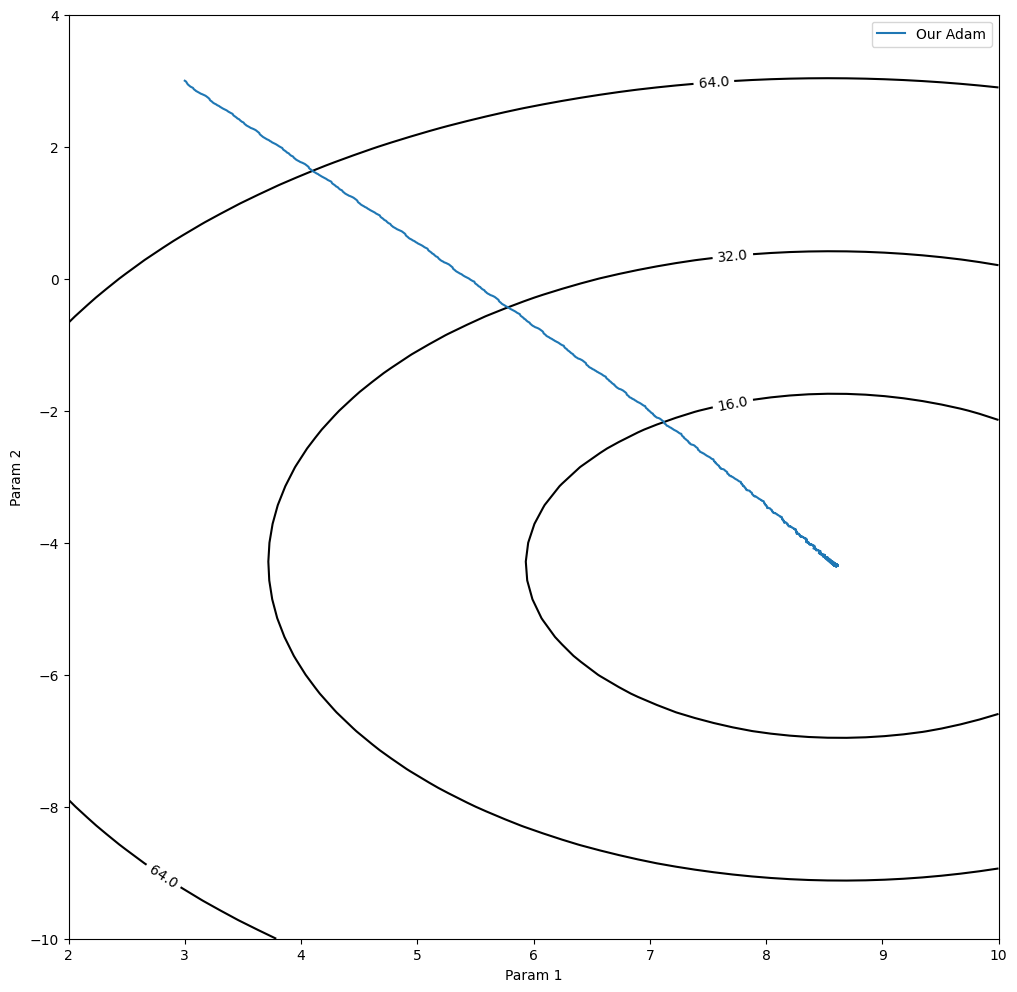

In [ ]:
fig = loss_fig(True) # Try this with smooth=False so we can see that the actual loss landscape is bumpy
ax = fig.gca()
ax.plot(adam_params[:,0], adam_params[:,1], label='Our Adam')
ax.legend()
fig

And finally, let's try out torch.optim.Adam.

In [ ]:
adam_params, adam_losses = get_parameters_over_training(optim.Adam)

40.891285 [3.4395165 2.4636216]
4.7991123 [ 7.078269  -2.0884247]
35.416134 [ 8.504409 -4.197674]
38.797443 [ 8.607367 -4.354989]
38.93859 [ 8.612156  -4.3609967]


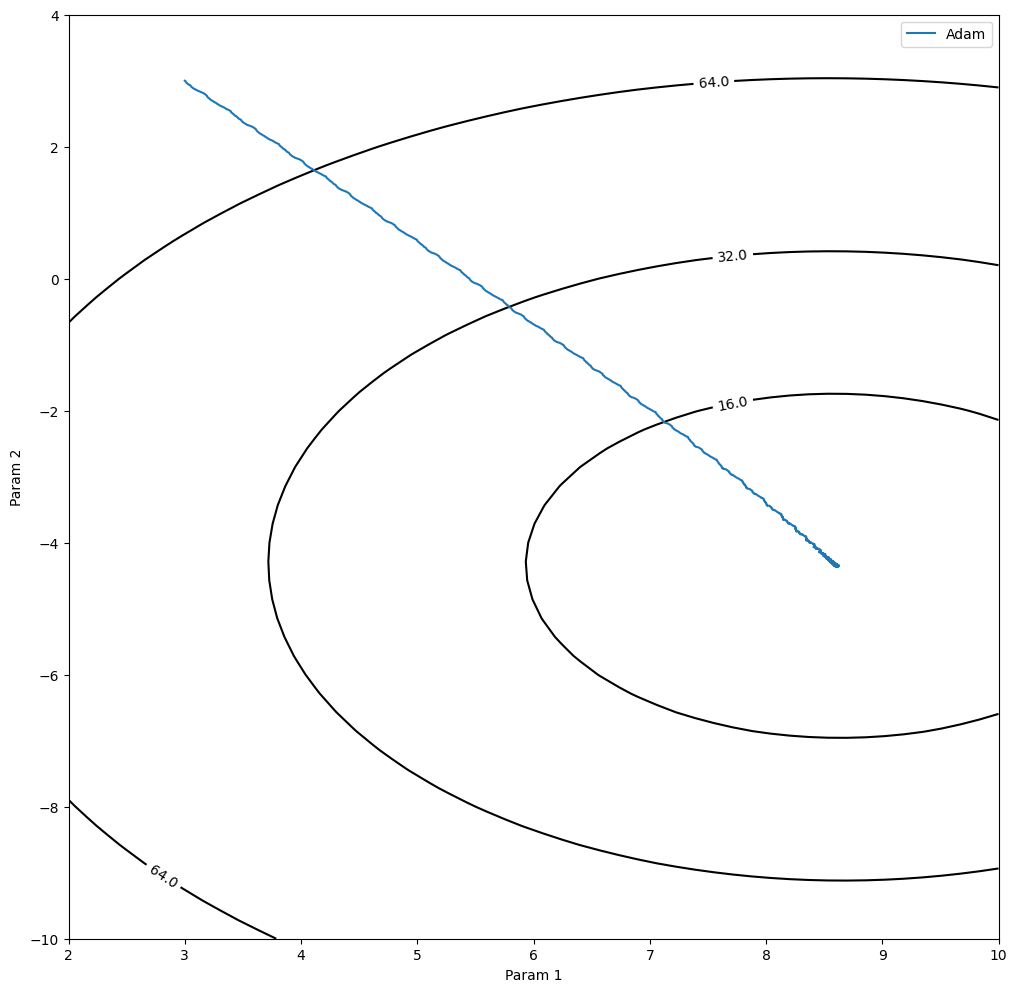

In [ ]:
fig = loss_fig(True)
ax = fig.gca()
ax.plot(adam_params[:,0], adam_params[:,1], label='Adam')
ax.legend()
fig

In this lesson, we implemented the Adam optomizer. Now that we've gone over a few optimizers, we can see that most optimizers are different skews on SGD. While there is ongoing research into different optimizers, many of them are actually small changes like the ones we reviewed that offer incremental improvements over existing optimizers.